# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import gc

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


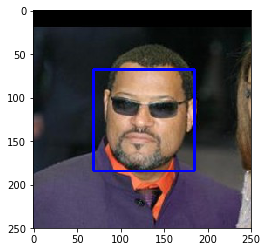

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    del img, gray
    gc.collect()
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- Percentage of the first 100 images in human_files have a detected human face: 99.00 %
- Percentage of the first 100 images in dog_files have a detected human face 11.00 %

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_files_detectedface =0;
dog_files_detectedface = 0;
count = 0
for i in range(0,100):
    count+=1
    if(face_detector(human_files_short[i])):
        human_files_detectedface+=1
    if(face_detector(dog_files_short[i])):
        dog_files_detectedface+=1
print("Percentage of the first 100 images in human_files have a detected human face: %0.2f" %(human_files_detectedface*100.0/(count)),"%")
print("Percentage of the first 100 images in dog_files have a detected human face %0.2f" %(dog_files_detectedface*100.0/(count)),"%")       
    

Percentage of the first 100 images in human_files have a detected human face: 99.00 %
Percentage of the first 100 images in dog_files have a detected human face 11.00 %


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ 
- When the systems were not "intelligent" enough it was acceptable to have expectation that user enters human images with a clear view of a face.<br> 
- With advances in deep learning algorithm, I beleieve that this is no longer a reasonable expectation and if the face is present in the image it should be detected with a very high accuracy. <br>
- System should automatically detect the face and if there is no face in the image then provide appropriate message to the user i.e. face is not detected and they should provide image with human face. <br>
- Deep learning based system could be used to detect and localize humans face using RCNN, Fast RCNN, Faster RCNN, Yolo ( Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242))
- If system cannot be improved for certain kind of images than user should be informed ahead of time for images where it may not work e.g. photos taken in dark where features are not clearly visible. 


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50
import h5py
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    del img
    gc.collect();
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- Percentage of the images in human_files_short have a detected dog: 1.00 % <br>
- Percentage of the images in dog_files_short have a detected dog: 100.00 %

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_detecteddog =0;
dog_files_detecteddog = 0;
count = 0
for i in range(0,100):
    count+=1
    if(dog_detector(human_files_short[i])):
        human_files_detecteddog+=1
    if(dog_detector(dog_files_short[i])):
        dog_files_detecteddog+=1

print("Percentage of the images in human_files_short have a detected dog: %0.2f" %(human_files_detecteddog*100.0/(count)),'%')
print("Percentage of the images in dog_files_short have a detected dog: %0.2f" %(dog_files_detecteddog*100.0/(count)),'%')

Percentage of the images in human_files_short have a detected dog: 1.00 %
Percentage of the images in dog_files_short have a detected dog: 100.00 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [01:41<00:00,  8.31it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ CNN architecture work well for the image classification task because it is can extract the structrual information(features) efficiently from the image using the convolution and pooling operation. These features are than feeded to dense layer (traditional neural network approach) to perform the classification task. 
- The CONV2D layer extract features from the input image and also preseves the spatial relation ship between pixels. Additionally, convolution is performed with many distinct filters simultaneoulsy and thus extract more image features get extracted. More the number of filters our network becomes good at recognizing patterns.
- Pooling layer help to reduce the dimensionality of spatial feature map and by using the maximum operation we are able to retain the most important information. This layers help to control the overfitting problem. It enables the scale invariant representation, thus we can detect object anywhere in the image.
- The fully connected layer is traditional neural network approach where each neuron is previous layer is connected to every neuron in next layer. Since the convolution and pooling layer are able extract the high-level features from the image, fully connected layer can use this feature and classify the input image based on the training dataset. Global Average Pooling (GAP) layers help to minimize the overfitting problem by reducing total number of parameters in the model. It provides the average of each feature making it robust to spatial translation. One could also use the Flatten and it gave better results. 
- Final dense layer consist of output node equal to the number of classes required for the classification task and the use of softmax operation help to classify. Other classifier could be used for the last task but for this work I just use the simple softmax.  
- I experimented with a few setup changing number of dense layer and the filter depth etc. This setup was giving me the better accuracy on the validation data. When I ran for 10 epochs, this network continously increased the validation accuracy compared to other architecutre where it wouldn't increase validation accuracy consistently as this architecture. Although, it was not an exhaustive search on parameters so there could be a better setup.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.layers import Dropout, Flatten, Dense 
from keras.models import Sequential


### TODO: Define your architecture.
total_class = len(dog_names)
input_shape = train_tensors[1,:].shape;
convFiltLength1 = 16
filtsize1 = 2
convFiltLength2 = 32
filtsize2 = 2
convFiltLength3 = 64
filtsize3 = 2

model = Sequential()
model.add(Conv2D(convFiltLength1, filtsize1, padding='valid',strides=1,activation='relu',input_shape=input_shape,name='conv2d_1'))
model.add(MaxPooling2D(2, name='max_pooling2d_1'))
model.add(Conv2D(convFiltLength2, filtsize2,padding='valid',strides=1,activation='relu',name='conv2d_2'))
model.add(MaxPooling2D(2, name='max_pooling2d_2'))
model.add(Conv2D(convFiltLength3, filtsize3,padding='valid',activation='relu',name='conv2d_3'))
model.add(MaxPooling2D(2, name='max_pooling2d_3'))
model.add(Conv2D(convFiltLength3*2, filtsize3,padding='valid',activation='relu',name='conv2d_4'))
model.add(MaxPooling2D(2, name='max_pooling2d_4'))
#model.add(Conv2D(convFiltLength3*4, filtsize3,padding='valid',strides=1,activation='relu',name='conv2d_5'))
#model.add(MaxPooling2D(2, name='max_pooling2d_5'))
#model.add(Conv2D(convFiltLength3*8, filtsize3,padding='valid',strides=1,activation='relu',name='conv2d_6'))
#model.add(MaxPooling2D(2, name='max_pooling2d_6'))
model.add(Flatten())
#model.add(GlobalAveragePooling2D(name='global_average_pooling2d_1'))
model.add(Dense(512, activation='tanh', name='dense_1')) # Same length as the conv filter depth
model.add(Dense(512 , activation='tanh', name='dense_2'))
model.add(Dense(total_class , activation='softmax', name='dense_3'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       32896     
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
Epoch 00000: val_loss improved from inf to 4.36158, saving model to saved_models/weights.best.from_scratch.hdf5
240s - loss: 4.6757 - acc: 0.0283 - val_loss: 4.3616 - val_acc: 0.0419
Epoch 2/5
Epoch 00001: val_loss improved from 4.36158 to 4.11190, saving model to saved_models/weights.best.from_scratch.hdf5
241s - loss: 4.1142 - acc: 0.0802 - val_loss: 4.1119 - val_acc: 0.0874
Epoch 3/5
Epoch 00002: val_loss did not improve
244s - loss: 3.2872 - acc: 0.2139 - val_loss: 4.3885 - val_acc: 0.0886
Epoch 4/5
Epoch 00003: val_loss did not improve
245s - loss: 1.8399 - acc: 0.5549 - val_loss: 4.5849 - val_acc: 0.0946
Epoch 5/5
Epoch 00004: val_loss did not improve
244s - loss: 0.5508 - acc: 0.8891 - val_loss: 5.0910 - val_acc: 0.1066


### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.9282%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 11.33289, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 12.7701 - acc: 0.1180 - val_loss: 11.3329 - val_acc: 0.2012
Epoch 2/20
Epoch 00001: val_loss improved from 11.33289 to 10.79707, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.9099 - acc: 0.2540 - val_loss: 10.7971 - val_acc: 0.2611
Epoch 3/20
Epoch 00002: val_loss improved from 10.79707 to 10.56347, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.5351 - acc: 0.3043 - val_loss: 10.5635 - val_acc: 0.2850
Epoch 4/20
Epoch 00003: val_loss improved from 10.56347 to 10.47629, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.2717 - acc: 0.3277 - val_loss: 10.4763 - val_acc: 0.2946
Epoch 5/20
Epoch 00004: val_loss improved from 10.47629 to 10.32226, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.0867 - acc: 0.3490 - val_loss: 10.3223 - val_acc: 

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.9952%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features extract_VGG16
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
def getBottleneckFeature(network):
    bottleneck_features = np.load('bottleneck_features/Dog'+network+'Data.npz')
    train_features = bottleneck_features['train']
    valid_features = bottleneck_features['valid']
    test_features = bottleneck_features['test']
    return train_features,valid_features,test_features

train_VGG19,valid_VGG19,test_VGG19 = getBottleneckFeature('VGG19')
train_Resnet50,valid_Resnet50,test_Resnet50 = getBottleneckFeature('Resnet50')
train_VGG16,valid_VGG16,test_VGG16 = getBottleneckFeature('VGG16') #Features already present as given by Udacity
train_InceptionV3,valid_InceptionV3,test_InceptionV3 = getBottleneckFeature('InceptionV3')
train_Xception,valid_Xception,test_Xception = getBottleneckFeature('Xception')



### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Generally for a image classification task, an architecture with repeated blocks of convolution and max pooling layers is used for extracting the spatially invarriant features. This is followed by by a two or more densely connected layers for the classification task. The final dense layer uses the softmax activation function and a node for each potential object category. 

For transfer learning, generally the last few dense layers are replaced or re-trainned to get better accuracy for the own classification problem. Since the Conv and pooling task is related to feature extraction process, parameters optimized for other images may still be valid and optimal for our task that also requires feature extraction. We just need to optimize the classifier part based on our training data set i.e. replace last few dense layers with a new architecture.  

- Global Average Pooling (GAP) layers help to minimize the overfitting problem by reducing total number of parameters in the model. It provides the average of each feature making it robust to spatial translation. Flatten didn't give good result as average pooling, maybe the feature were trained on different dataset so it does not perform well. So instead of choosing to flatten, I decided to go with GAP
- Added two Dense layers with the tanh activiation function. Tanh seemed to work better than default option. I tried to RELU but it didn't give better results. Didn't try other advanced activation function such as leaky RELU, maybe it could provide better results.
- For optimizer, literature search shows that Adam algorithm is better than rmsprop, hence used that algorithm for optimizer
- Choose to have a final dense layer consisted of 133 node with softmax activation function since there are 133 dog breeds. 
- Batch size of 20 seems to be small. I experimented with a few number and it seems 64/128/256 will be a better choice, if I run for less epochs. I kept 256 because it gave me better results on the validation data.
- Based on the original paper of Resnet50, it appears that this netwoark may be good at extracting features from images as it allows training exteremly deep network due to its "network-in-network" architecture. Hence we can expect that it will gives the highest classification accuracy. Other two model Xception and InceptionV3 should also give comparable results. In order to evaluate it all models were evaluated for transfer learning. 


In [26]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D,AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

    
def createModelToClassifyDogBreed(features):
    network_model = Sequential()
    input_shape = features.shape[1:];
    network_model.add(GlobalAveragePooling2D(input_shape=input_shape))
    #network_model.add(Flatten(input_shape=input_shape))
    network_model.add(Dense(input_shape[2], activation='tanh',name='Dense_1'))
    network_model.add(Dense(512, activation='tanh',name='Dense_2'))
    network_model.add(Dense(133, activation='softmax',name='Dense_3'))
    network_model.summary()
    return network_model

print("Model based on VGG19:\n")
VGG19_model = createModelToClassifyDogBreed(train_VGG19)
print("Model based on Xception:\n")
Xception_model = createModelToClassifyDogBreed(train_Xception)
print("Model based on InceptionV3:\n")
InceptionV3_model = createModelToClassifyDogBreed(train_InceptionV3)
print("Model based on Resnet50:\n")
Resnet50_model = createModelToClassifyDogBreed(train_Resnet50)
print("Model based on VGG16:\n")
VGG16_model = createModelToClassifyDogBreed(train_VGG16) #Overwrite the old model provided by the Udacity



Model based on VGG19:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
Dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
Dense_3 (Dense)              (None, 133)               68229     
Total params: 593,541.0
Trainable params: 593,541.0
Non-trainable params: 0.0
_________________________________________________________________
Model based on Xception:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_______________

### (IMPLEMENTATION) Compile the Model

In [27]:
### TODO: Compile the model.
def compileModel(model):
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    
compileModel(VGG19_model)
compileModel(Xception_model)
compileModel(InceptionV3_model)
compileModel(Resnet50_model)
compileModel(VGG16_model)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [28]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  
def trainNetwork(network,train_feature,train_targets,validation_data,model, epochs, batch_size):
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.'+ network + '.hdf5', 
                               verbose=1, save_best_only=True)
    model.fit(train_feature, train_targets, epochs=epochs, batch_size=batch_size, 
          validation_data=validation_data,
          callbacks=[checkpointer], verbose=2)
    
 #Perform training of the required model   

epochs=20
batch_size=256
print("Training network: VGG16")
trainNetwork('VGG16',train_VGG16,train_targets,(valid_VGG16,valid_targets),VGG16_model,epochs, batch_size)
print("Training network: VGG19")
trainNetwork('VGG19',train_VGG19,train_targets,(valid_VGG19,valid_targets),VGG19_model,epochs, batch_size)
print("Training network: Xception")
trainNetwork('Xception',train_Xception,train_targets,(valid_Xception,valid_targets),Xception_model,epochs, batch_size)
print("Training network: InceptionV3")
trainNetwork('InceptionV3',train_InceptionV3,train_targets,(valid_InceptionV3,valid_targets),InceptionV3_model,epochs, batch_size)
print("Training network: Resnet50")
trainNetwork('Resnet50',train_Resnet50,train_targets,(valid_Resnet50,valid_targets),Resnet50_model,epochs, batch_size)

Training network: VGG16
Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 1.80159, saving model to saved_models/weights.best.VGG16.hdf5
2s - loss: 2.3524 - acc: 0.4774 - val_loss: 1.8016 - val_acc: 0.4814
Epoch 2/20
Epoch 00001: val_loss improved from 1.80159 to 1.19765, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 0.7591 - acc: 0.7936 - val_loss: 1.1977 - val_acc: 0.6419
Epoch 3/20
Epoch 00002: val_loss did not improve
1s - loss: 0.4584 - acc: 0.8795 - val_loss: 1.4622 - val_acc: 0.5976
Epoch 4/20
Epoch 00003: val_loss did not improve
1s - loss: 0.3554 - acc: 0.9108 - val_loss: 1.2193 - val_acc: 0.6551
Epoch 5/20
Epoch 00004: val_loss improved from 1.19765 to 1.03934, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 0.2599 - acc: 0.9388 - val_loss: 1.0393 - val_acc: 0.7018
Epoch 6/20
Epoch 00005: val_loss improved from 1.03934 to 1.00870, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss:

Epoch 12/20
Epoch 00011: val_loss did not improve
8s - loss: 0.0186 - acc: 0.9954 - val_loss: 0.5506 - val_acc: 0.8515
Epoch 13/20
Epoch 00012: val_loss did not improve
8s - loss: 0.0144 - acc: 0.9970 - val_loss: 0.5465 - val_acc: 0.8551
Epoch 14/20
Epoch 00013: val_loss did not improve
8s - loss: 0.0133 - acc: 0.9970 - val_loss: 0.5557 - val_acc: 0.8599
Epoch 15/20
Epoch 00014: val_loss did not improve
8s - loss: 0.0135 - acc: 0.9967 - val_loss: 0.5592 - val_acc: 0.8539
Epoch 16/20
Epoch 00015: val_loss did not improve
8s - loss: 0.0086 - acc: 0.9981 - val_loss: 0.7315 - val_acc: 0.8299
Epoch 17/20
Epoch 00016: val_loss did not improve
8s - loss: 0.0208 - acc: 0.9966 - val_loss: 0.5655 - val_acc: 0.8479
Epoch 18/20
Epoch 00017: val_loss did not improve
8s - loss: 0.0107 - acc: 0.9982 - val_loss: 0.7760 - val_acc: 0.8287
Epoch 19/20
Epoch 00018: val_loss did not improve
8s - loss: 0.1034 - acc: 0.9763 - val_loss: 6.0537 - val_acc: 0.2743
Epoch 20/20
Epoch 00019: val_loss did not improv

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [29]:
### TODO: Load the model weights with the best validation loss.
def loadBestModel(network,model):
    model.load_weights('saved_models/weights.best.'+network+'.hdf5')
    
loadBestModel('VGG19',VGG19_model)
loadBestModel('Xception',Xception_model)
loadBestModel('InceptionV3',InceptionV3_model)
loadBestModel('Resnet50',Resnet50_model)
loadBestModel('VGG19',VGG19_model)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [30]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
def model_predictions(network_model,test_network):
    model_predictions = [np.argmax(network_model.predict(np.expand_dims(feature, axis=0))) for feature in test_network]
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    #print('Test accuracy: %.4f%%' % test_accuracy)
    return model_predictions,test_accuracy

print("Test: VGG19\n")
VGG19_predictions,VGG19_test_accuracy = model_predictions(VGG19_model,test_VGG19)

print("Test: Xception\n")
Xception_predictions,Xception_test_accuracy = model_predictions(Xception_model,test_Xception)

print("Test: InceptionV3\n")
InceptionV3_predictions,InceptionV3_test_accuracy = model_predictions(InceptionV3_model,test_InceptionV3)

print("Test: Resnet50\n")
Resnet50_predictions,Resnet50_test_accuracy = model_predictions(Resnet50_model,test_Resnet50)

print("Test: VGG16\n")
VGG16_predictions,VGG16_test_accuracy = model_predictions(VGG16_model,test_VGG16)

print("Summary Test Results for different Network :\n")
print("VGG16       : %0.2f"%VGG16_test_accuracy+"%\n")
print("VGG19       : %0.2f"%VGG19_test_accuracy+"%\n")
print("Xception    : %0.2f"%Xception_test_accuracy+"%\n")
print("Resnet50    : %0.2f"%Resnet50_test_accuracy+"%\n")
print("InceptionV3 : %0.2f"%InceptionV3_test_accuracy+"%\n")


Test: VGG19

Test: Xception

Test: InceptionV3

Test: Resnet50

Test: VGG16

Summary Test Results for different Network :

VGG16       : 79.55%

VGG19       : 82.06%

Xception    : 85.65%

Resnet50    : 84.45%

InceptionV3 : 83.61%



### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
#from extract_bottleneck_features import *
import gc;
def cleanMemory(varList):
    for name in varList:
        if name in globals():
            del globals()[name]
    gc.collect();
    
def VGG19_predict_breed(img_path):
    # extract bottleneck features
    
    img_tensor = path_to_tensor(img_path)
    bottleneck_features = extract_VGG19(img_tensor);
    #print("End BN Feature")
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_features);
    dog_name = dog_names[np.argmax(predicted_vector)]
    prob_val = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    cleanMemory(['bottleneck_features','img_tensor','predicted_vector']) 
    return dog_name,prob_val;

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    
    img_tensor = path_to_tensor(img_path)
    bottleneck_features = extract_VGG16(img_tensor);
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_features);
    # return dog breed that is predicted by the model
    dog_name =dog_names[np.argmax(predicted_vector)]
    prob_val = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    cleanMemory(['bottleneck_features','img_tensor','predicted_vector']) 
    return dog_name,prob_val;

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    img_tensor = path_to_tensor(img_path)
    bottleneck_features = extract_Resnet50(img_tensor);
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_features);
    # return dog breed that is predicted by the model
    dog_name = dog_names[np.argmax(predicted_vector)]
    prob_val = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    cleanMemory(['bottleneck_features','img_tensor','predicted_vector']) 
    return dog_name,prob_val;

def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    img_tensor = path_to_tensor(img_path)
    bottleneck_features = extract_InceptionV3( img_tensor);
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_features);
    dog_name = dog_names[np.argmax(predicted_vector)]
    prob_val = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    cleanMemory(['bottleneck_features','img_tensor','predicted_vector']) 
    return dog_name,prob_val;

def Xception_predict_breed(img_path):
    # extract bottleneck features
    img_tensor = path_to_tensor(img_path)
    bottleneck_features = extract_Xception(img_tensor);
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_features);
    dog_name = dog_names[np.argmax(predicted_vector)]
    prob_val = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    cleanMemory(['bottleneck_features','img_tensor','predicted_vector']) 
    return dog_name,prob_val;

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [32]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def identifyDogBreed(inputFile):
    #print("ID Dog Breed")
    # Find if dog is present
    hasDog = dog_detector(inputFile)
    hasHuman = face_detector(inputFile)
    
    if(hasDog | hasHuman):
        #print("Breed Type Complete")
        VGG16_breedtype = VGG16_predict_breed(inputFile);
        VGG19_breedtype = VGG19_predict_breed(inputFile);
        Resnet50_breedtype = Resnet50_predict_breed(inputFile);
        InceptionV3_breedtype = InceptionV3_predict_breed(inputFile);
        Xception_breedtype = Xception_predict_breed(inputFile);
       # print("Breed Type Complete")
        
        breed_type = "\n"
        breed_type = breed_type+"expert-VGG16 is        :" + VGG16_breedtype[0] + " with probability of %0.2f"%( VGG16_breedtype[1]*100)+ "%\n";
        breed_type = breed_type+"expert-VGG19 is        :" + VGG19_breedtype [0]  + " with probability of %0.2f"%(VGG19_breedtype[1]*100)+ "%\n";
        breed_type = breed_type+"expert-Resnet50 is     :" + Resnet50_breedtype [0] + " with probability of %0.2f"%(Resnet50_breedtype[1]*100)+ "%\n";
        breed_type = breed_type+"expert-InceptionV3 is  :" + InceptionV3_breedtype [0]  + " with probability of %0.2f"%( InceptionV3_breedtype[1]*100)+ "%\n";
        breed_type = breed_type+"expert-Xception is     :" + Xception_breedtype [0]  + " with probability of %0.2f"%(Xception_breedtype[1]*100)+ "%\n";
        
        delVar =['VGG16_breedtype','VGG19_breedtype','Resnet50_breedtype','InceptionV3_breedtype','Xception_breedtype']
        cleanMemory(delVar)
    
        if(hasDog):
            cleanMemory(['hasDog','hasHuman'])
            #print("Complete ID Dog Breed")
            return ('Hello dog!\n Your breed according to \n'+breed_type)
        else:
            cleanMemory(['hasDog','hasHuman'])
            #print("Complete ID Dog Breed")
            return ('Hello Human!\n Resembling dog breed according to  \n' + breed_type)
    else:
        cleanMemory(['hasDog','hasHuman'])
        #print("Complete ID Dog Breed")
        return 'Error: No human or dog found in the picture'


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ I am no expert in the dog breed classification and surely have accuracy of less than 1%, hence I was hopping that the system would perform better than me for sure. 
- I was a bit skeptical that algorithm will work on images that had a black dog in black background but to surprise it did perform well on those images (both dog and cat). 
- It could not detect dog in a image that had a water in the background, that was unexpected.
- System didn't work well in finding human, when clear view of the face was not available. Probably a deep-learning based system would perform better.

Following improvement can be done to the algorithm:
- Use You Only Look Once (Yolo) algorithm to detect the total dog faces and human faces in the image. Then each detected human and dog, should be provided with the dog breed type. 
- Training accuracy and validation accuracy have a large difference, so there is probably there is high variance and optimzation is required for the network. Hence could look into methods for reducing it e.g. trying different dropout rate, regularization, look at possibility of adding more data via data augmentation. 
- Dog breed classification seems a though problem, so probably look at the multi-expert system approach for classification to have the final classification result.
- There is a memory leak some where in the bottleneck feature extraction. It appears that RAM memory used by python is not cleared after calling that function. Hence I could not run all images at once. Hence presenting result for first 10 images only as it use 10GB of RAM that cannot be freed unless I do kernel reset. I ran for 50 images while expermenting separetely but including results for only 10 here. 

Next Prediction on Filename:  vijay_test_image/test1.jpg


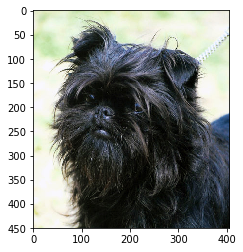

Hello dog!
 Your breed according to 

expert-VGG16 is        :Affenpinscher with probability of 99.99%
expert-VGG19 is        :Affenpinscher with probability of 99.96%
expert-Resnet50 is     :Affenpinscher with probability of 99.39%
expert-InceptionV3 is  :Affenpinscher with probability of 99.87%
expert-Xception is     :Affenpinscher with probability of 99.99%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test2.jpg


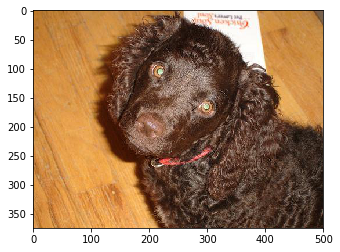

Hello dog!
 Your breed according to 

expert-VGG16 is        :Curly-coated_retriever with probability of 97.28%
expert-VGG19 is        :Poodle with probability of 30.50%
expert-Resnet50 is     :American_water_spaniel with probability of 50.99%
expert-InceptionV3 is  :American_water_spaniel with probability of 94.45%
expert-Xception is     :Curly-coated_retriever with probability of 95.09%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test3.jpg


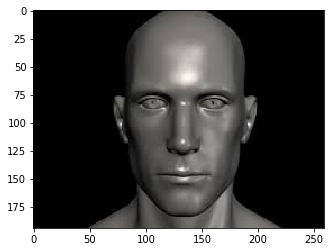

Hello Human!
 Resembling dog breed according to  

expert-VGG16 is        :Maltese with probability of 38.25%
expert-VGG19 is        :Dogue_de_bordeaux with probability of 25.95%
expert-Resnet50 is     :Bichon_frise with probability of 12.42%
expert-InceptionV3 is  :Bull_terrier with probability of 33.07%
expert-Xception is     :English_cocker_spaniel with probability of 12.49%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test4.jpg


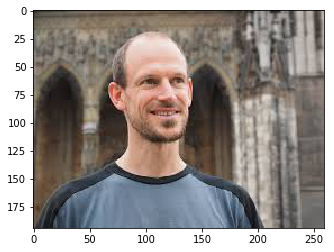

Hello Human!
 Resembling dog breed according to  

expert-VGG16 is        :Chow_chow with probability of 31.01%
expert-VGG19 is        :Dogue_de_bordeaux with probability of 16.41%
expert-Resnet50 is     :Silky_terrier with probability of 28.75%
expert-InceptionV3 is  :Clumber_spaniel with probability of 39.53%
expert-Xception is     :Borzoi with probability of 20.21%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test5.jpg


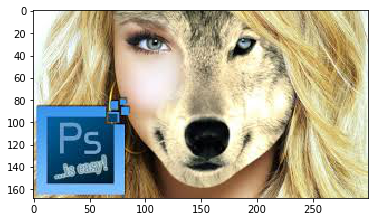

Hello dog!
 Your breed according to 

expert-VGG16 is        :Afghan_hound with probability of 85.95%
expert-VGG19 is        :Collie with probability of 74.28%
expert-Resnet50 is     :Afghan_hound with probability of 78.14%
expert-InceptionV3 is  :Afghan_hound with probability of 42.73%
expert-Xception is     :Afghan_hound with probability of 98.51%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test6.jpg


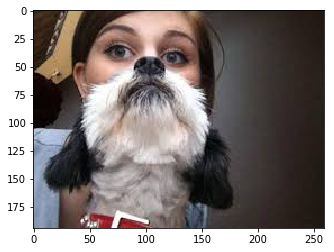

Hello dog!
 Your breed according to 

expert-VGG16 is        :English_toy_spaniel with probability of 38.09%
expert-VGG19 is        :Japanese_chin with probability of 48.83%
expert-Resnet50 is     :English_toy_spaniel with probability of 49.48%
expert-InceptionV3 is  :Lhasa_apso with probability of 96.18%
expert-Xception is     :Lhasa_apso with probability of 96.31%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test7.jpg


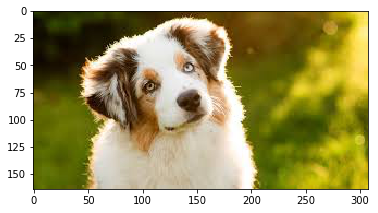

Hello dog!
 Your breed according to 

expert-VGG16 is        :Australian_shepherd with probability of 93.91%
expert-VGG19 is        :Australian_shepherd with probability of 59.91%
expert-Resnet50 is     :Australian_shepherd with probability of 82.89%
expert-InceptionV3 is  :Brittany with probability of 45.36%
expert-Xception is     :Australian_shepherd with probability of 76.76%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test8.jpg


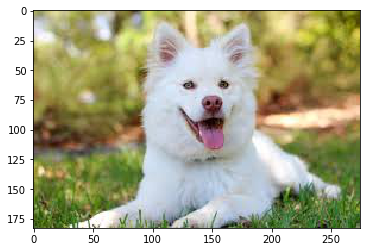

Hello dog!
 Your breed according to 

expert-VGG16 is        :American_eskimo_dog with probability of 98.76%
expert-VGG19 is        :American_eskimo_dog with probability of 99.53%
expert-Resnet50 is     :American_eskimo_dog with probability of 99.01%
expert-InceptionV3 is  :American_eskimo_dog with probability of 99.84%
expert-Xception is     :American_eskimo_dog with probability of 99.33%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test9.jpg


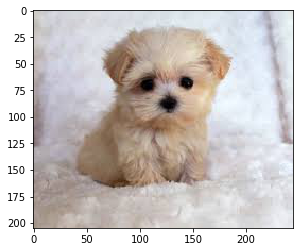

Hello dog!
 Your breed according to 

expert-VGG16 is        :Maltese with probability of 89.88%
expert-VGG19 is        :Maltese with probability of 91.62%
expert-Resnet50 is     :Maltese with probability of 51.62%
expert-InceptionV3 is  :Norfolk_terrier with probability of 60.14%
expert-Xception is     :Maltese with probability of 87.47%


---------------------------------------------------------------

Next Prediction on Filename:  vijay_test_image/test10.jpg


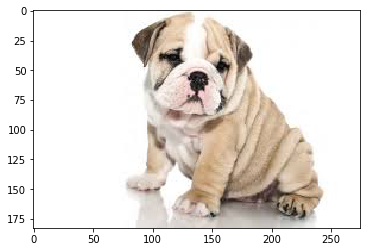

Hello dog!
 Your breed according to 

expert-VGG16 is        :Bulldog with probability of 99.82%
expert-VGG19 is        :Bulldog with probability of 97.59%
expert-Resnet50 is     :Bulldog with probability of 99.49%
expert-InceptionV3 is  :Bulldog with probability of 99.99%
expert-Xception is     :Bulldog with probability of 97.28%


---------------------------------------------------------------



In [33]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

#from sklearn.datasets import load_files       
#from keras.utils import np_utils
#import numpy as np
#from glob import glob
#import cv2                
#import matplotlib.pyplot as plt                        
#%matplotlib inline  
import gc

# Memory filled with data no longer need. To avoid causing crash, Cleaning up memory by removing those variables.
delVar = ['human_files','train_files', 'train_targets', 'valid_files', 'valid_targets','test_files', 'test_targets','train_tensors', 'valid_tensors', 'test_tensors','train_VGG16', 'test_VGG16', 'valid_VGG16','train_VGG19', 'test_VGG19', 'valid_VGG19','train_Resnet50', 'test_Resnet50', 'valid_Resnet50','train_InceptionV3','valid_InceptionV3','test_InceptionV3','train_Xception','valid_Xception','test_Xception']
cleanMemory(delVar)

        
numimg = 10;



for i in range(1,numimg+1):
    testFilename = (("vijay_test_image/test" + str(i) + ".jpg"))
    print('Next Prediction on Filename: ',testFilename)
          
    result = identifyDogBreed(testFilename);
    # load color (BGR) image
    img = cv2.imread(testFilename);
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    
    # display the image, along with bounding box
    plt.imshow(cv_rgb);
    plt.show();
    print(result +'\n')
    print("---------------------------------------------------------------" +'\n')
    plt.clf();
    delList =['img','cv_rgb','result','testFilename']
    cleanMemory(delList)
    gc.get_stats()
   
    #print('Filename: ',testFilename,'Prediction Finished\n')

    
